# 04 - Técnicas de Balanceo de Clases

Este notebook implementa y compara sistemáticamente tres familias de técnicas de balanceo de clases en nuestro problema de riesgo crediticio desbalanceado. Evitaremos realizar tuning y optimización computacional aquí. El objetivo es identificar qué técnica y modelo ofrecen el mejor equilibrio entre encontrar morosos (alto recall) y no clasificar incorrectamente a buenos (precision).

Secciones:
1) Ponderación de clases (class_weight/scale_pos_weight) 
2) Oversampling con SMOTE (en una muestra estratificada 30%)
3) Oversampling con ADASYN (mismas condiciones que SMOTE)
4) Tabla comparativa final y análisis


In [ ]:
# Librerías básicas para cargue y uso de dataset
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import hashlib
import json

ROOT = r'C:\\MachineLearningPG'
DATA_DIR = os.path.join(ROOT, 'data')
REPORTS_DIR = os.path.join(ROOT, 'reports')
os.makedirs(REPORTS_DIR, exist_ok=True)

proc_path = os.path.join(DATA_DIR, 'processed_for_modeling.csv')
assert os.path.exists(proc_path), f'Processed file not found: {proc_path}'
df = pd.read_csv(proc_path)
# Quitar columnas índice si existieran
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

target = 'SeriousDlqin2yrs'
X = df.drop(columns=[target])
y = df[target].astype(int)
print('Dataset shape:', X.shape, 'Target distribution:', y.value_counts().to_dict())

have_xgb = False
scale_pos_weight = 1.0
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    have_xgb = True
    pos = int((y == 1).sum())
    neg = int((y == 0).sum())
    if pos > 0:
        scale_pos_weight = neg / pos
    print('XGBoost disponible. scale_pos_weight =', scale_pos_weight)
except Exception as e:
    have_xgb = False
    print('XGBoost no disponible; se omitirá XGBoost. Error:', e)

Dataset shape: (150000, 16) Target distribution: {0: 139974, 1: 10026}
XGBoost disponible. scale_pos_weight = 13.961101137043686


### Evaluación del Balanceo por Ponderación de Clases

Nuestra primera estrategia será evaluar la técnica de balanceo más eficiente computacionalmente: la **(Class Weighting)**. Este método no modifica el dataset, sino que ajusta el algoritmo de aprendizaje para que penalice con mayor severidad los errores cometidos sobre la clase minoritaria.

Para llevar a cabo una comparación justa y directa, el siguiente bloque de código prepara dos grupos de estimadores:

1.  **`base_estimators`**: Un diccionario que contiene las versiones estándar (sin balancear) de todos los modelos de nuestro benchmark. Estos servirán como el "baseline" para medir el impacto de las técnicas de balanceo dentro de este mismo notebook.
2.  **`weighted_estimators`**: Un diccionario que contiene únicamente los modelos que soportan de forma nativa la ponderación de clases. Se utiliza el parámetro `class_weight='balanced'` para los modelos de `scikit-learn` y el equivalente `scale_pos_weight` para `XGBoost`.

In [ ]:
# Pipeline de Estimadores BASE (sin ponderación)
base_estimators = {
    'Logistic_L2': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000, random_state=42))
    ]),
    'Logistic_L1': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'GaussianNB': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GaussianNB())
    ]),
    'DecisionTree': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'LinearSVC': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(random_state=42))
    ])
}

if have_xgb:
    base_estimators['XGBoost'] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            tree_method='hist',
            eval_metric='logloss',
            n_jobs=-1,
            verbosity=0,
        ))
    ])

# Estimadores PONDERADOS (class_weight/scale_pos_weight)
weighted_estimators = {
    'Logistic_L2_weighted': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000, random_state=42, class_weight='balanced'))
    ]),
    'Logistic_L1_weighted': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42, class_weight='balanced'))
    ]),
    'RandomForest_weighted': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'))
    ]),
}

if have_xgb:
    weighted_estimators['XGBoost_weighted'] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            tree_method='hist',
            eval_metric='logloss',
            n_jobs=-1,
            verbosity=0,
            scale_pos_weight=scale_pos_weight
        ))
    ])

print('Base estimators:', list(base_estimators.keys()))
print('Weighted estimators:', list(weighted_estimators.keys()))

Base estimators: ['Logistic_L2', 'Logistic_L1', 'RandomForest', 'KNN', 'GaussianNB', 'DecisionTree', 'LinearSVC', 'XGBoost']
Weighted estimators: ['Logistic_L2_weighted', 'Logistic_L1_weighted', 'RandomForest_weighted', 'XGBoost_weighted']


### Helpers
En esta sección definiremos algunas funciones de ayuda, que conformarán el núcleo de nuestro framework de evaluación.

*   **`get_cv_scores`**: Esta es la función principal de **cómputo**. Utiliza validación cruzada para generar predicciones Out-of-Fold y calcula un conjunto completo de métricas de rendimiento (AUC, AP, F1-Score, etc.). Está diseñada para ser compatible con cualquier clasificador de `scikit-learn`, adaptándose a si el modelo devuelve probabilidades o scores de decisión. La función **retorna un diccionario** con los resultados, sin imprimir nada.

*   **`pretty_print_metrics`**: Se encarga de la **presentación** de los resultados, las metricas.

*   **`show_and_save_confusion`**: Se especializa en **visualizar y guardar** la matriz de confusión, manteniendo un estilo visual consistente (`cmap='Reds'`) en todos los gráficos.


In [ ]:

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
VINOTINTO_CMAP = 'Reds' 

def show_and_save_confusion(cm, name):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(4.5, 3.8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=VINOTINTO_CMAP, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    cm_path = os.path.join(REPORTS_DIR, f'confusion_matrix_{name}.png')
    plt.savefig(cm_path, dpi=150)
    plt.show()
    return cm_path


def get_cv_scores(estimator, X, y):
    proba = None
    scores = None
    try:
        proba = cross_val_predict(estimator, X.fillna(0), y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]
    except Exception:
        try:
            scores = cross_val_predict(estimator, X.fillna(0), y, cv=skf, method='decision_function', n_jobs=-1)
        except Exception:
            pass
    if proba is None and scores is None:
        y_pred = cross_val_predict(estimator, X.fillna(0), y, cv=skf, method='predict', n_jobs=-1)
        auc = np.nan
        ap = np.nan
    else:
        if proba is None:
            s = scores
            s = (s - s.min()) / (s.max() - s.min() + 1e-9)
            proba = s
        y_pred = (proba >= 0.5).astype(int)
        auc = float(roc_auc_score(y, proba))
        ap = float(average_precision_score(y, proba))

    recall = float(recall_score(y, y_pred))
    f1 = float(f1_score(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    report_str = classification_report(y, y_pred, digits=4)
    report_dict = classification_report(y, y_pred, output_dict=True, digits=4)
    accuracy = float(report_dict.get('accuracy', np.nan))

    return {
        'auc': auc,
        'ap': ap,
        'accuracy': accuracy,
        'recall': recall,
        'f1': f1,
        'cm': cm,
        'report': report_str,
        'report_dict': report_dict
    }


def pretty_print_metrics(name, stats, technique=None):
    # Imprime métricas directamente (sin deduplicación para permitir re-ejecuciones)
    prefix = f"{technique}:{name}" if technique else name
    try:
        text = (
            f"Model: {prefix}\n"
            f"AUC: {stats.get('auc', float('nan')):.4f} | AP: {stats.get('ap', float('nan')):.4f}\n"
            f"Classification Report:\n{stats.get('report','')}"
        )
        print(text)
    except Exception as e:
        print('Error al imprimir métricas:', e)

# Sección 1: Ponderación de clases y baselines

### Evaluación del Balanceo por Ponderación de Clases

Iniciamos nuestras pruebas evaluando la técnica de balanceo más directa y computacionalmente eficiente: **class_weight='balanced'**. Este método ajusta el algoritmo de aprendizaje para que asigne una mayor importancia a los errores cometidos en la clase minoritaria (impago).

**Evaluación de Modelos Ponderados:** A continuación, se evalúan los modelos que soportan `class_weight` o `scale_pos_weight`. Para estos, los resultados **se muestran en detalle**, incluyendo el reporte de clasificación completo y la matriz de confusión.

Calculando baselines (silencioso)...
Calculando modelos ponderados...
Calculando modelos ponderados...
Model: weighted:Logistic_L2_weighted
AUC: 0.8544 | AP: 0.3779
Classification Report:
              precision    recall  f1-score   support

           0     0.9780    0.8003    0.8803    139974
           1     0.2116    0.7483    0.3299     10026

    accuracy                         0.7968    150000
   macro avg     0.5948    0.7743    0.6051    150000
weighted avg     0.9267    0.7968    0.8435    150000

Model: weighted:Logistic_L2_weighted
AUC: 0.8544 | AP: 0.3779
Classification Report:
              precision    recall  f1-score   support

           0     0.9780    0.8003    0.8803    139974
           1     0.2116    0.7483    0.3299     10026

    accuracy                         0.7968    150000
   macro avg     0.5948    0.7743    0.6051    150000
weighted avg     0.9267    0.7968    0.8435    150000



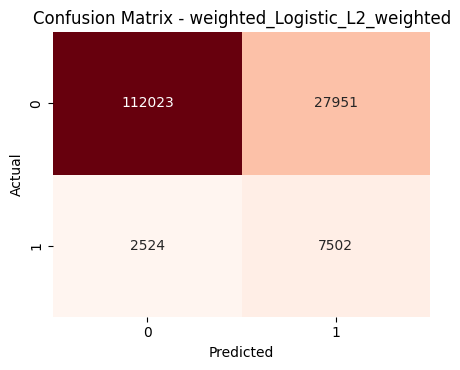

Model: weighted:Logistic_L1_weighted
AUC: 0.8544 | AP: 0.3779
Classification Report:
              precision    recall  f1-score   support

           0     0.9779    0.8006    0.8804    139974
           1     0.2118    0.7480    0.3301     10026

    accuracy                         0.7971    150000
   macro avg     0.5949    0.7743    0.6053    150000
weighted avg     0.9267    0.7971    0.8437    150000



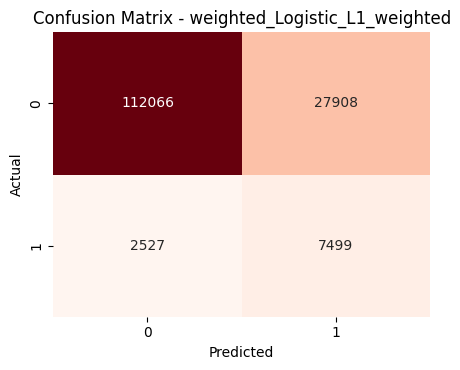

Model: weighted:RandomForest_weighted
AUC: 0.8356 | AP: 0.3260
Classification Report:
              precision    recall  f1-score   support

           0     0.9419    0.9901    0.9654    139974
           1     0.5175    0.1475    0.2296     10026

    accuracy                         0.9338    150000
   macro avg     0.7297    0.5688    0.5975    150000
weighted avg     0.9135    0.9338    0.9162    150000



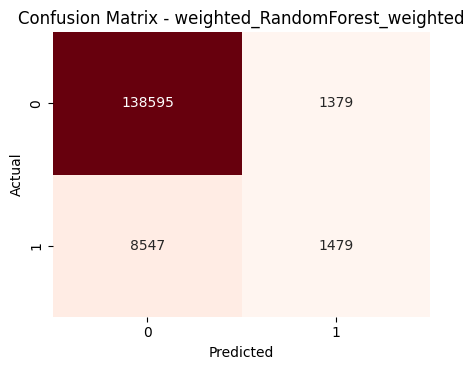

Model: weighted:XGBoost_weighted
AUC: 0.8557 | AP: 0.3758
Classification Report:
              precision    recall  f1-score   support

           0     0.9764    0.8290    0.8967    139974
           1     0.2317    0.7197    0.3505     10026

    accuracy                         0.8217    150000
   macro avg     0.6040    0.7744    0.6236    150000
weighted avg     0.9266    0.8217    0.8602    150000



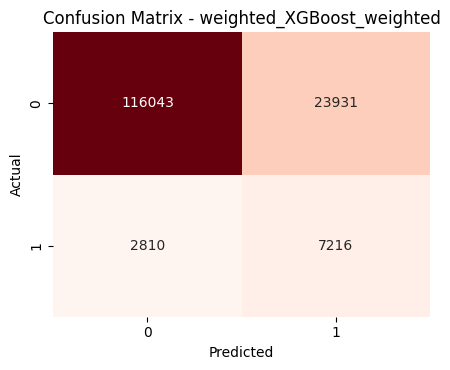

Saved Section 1 results


In [ ]:
section1_results = {}

print('Calculando baselines...')
for name, est in base_estimators.items():
    try:
        r = get_cv_scores(est, X, y)
        section1_results[f'baseline::{name}'] = r
    except Exception as e:
        print('  Baseline error en', name, ':', e)

print('Calculando modelos ponderados...')
for name, est in weighted_estimators.items():
    try:
        r = get_cv_scores(est, X, y)
        section1_results[f'weighted::{name}'] = r
        pretty_print_metrics(name, r, technique='weighted')
        show_and_save_confusion(r['cm'], f"weighted_{name}")
    except Exception as e:
        print('  Weighted error en', name, ':', e)

with open(os.path.join(REPORTS_DIR, 'sec1_weighting_and_baselines.json'), 'w') as f:
    json.dump(section1_results, f, default=lambda o: o.tolist() if hasattr(o, 'tolist') else str(o))
print('Saved Section 1 results')

### Análisis de Resultados de la Sección 1: Ponderación de Clases
#### Se Resuelve el Problema del Bajo `Recall`

El objetivo principal de esta sección era solucionar el bajísimo `recall` para la clase minoritaria (impago) que observamos en el benchmark inicial. Los resultados confirman un **éxito rotundo** en este aspecto, especialmente para los modelos lineales y XGBoost:

*   **Logistic Regression (L1/L2):** El `recall` para la clase `1` (impago) **aumentó drásticamente de ~0.16 a un impresionante ~0.75**. Esto significa que el modelo ahora es capaz de identificar correctamente al **75% de todos los clientes que realmente incurrirán en impago**, un salto masivo desde el 16% anterior.
*   **XGBoost:** De manera similar, su `recall` para la clase `1` se disparó a **~0.72 (72%)**.

A cambio de esta enorme ganancia en sensibilidad (recall), la `precision` ha disminuido, lo que era esperado. El **F1-Score** para la clase positiva se sitúa ahora en torno a **0.33 - 0.35** para estos modelos, estableciendo un nuevo y mucho más útil baseline de rendimiento.

#### Observación Interesante: El Comportamiento de RandomForest

A diferencia de los otros modelos, `RandomForest_weighted` no respondió tan positivamente a la ponderación de clases. Su `recall` para la clase `1` se mantuvo bajo (0.1475), y su F1-Score (0.2296) es significativamente inferior al de la Regresión Logística y XGBoost. Esto podría sugerir que, para este dataset, los modelos basados en árboles como Random Forest podrían beneficiarse más de técnicas que modifican la distribución de los datos (como SMOTE/ADASYN) en lugar de una simple ponderación de errores.

#### Veredicto Preliminar

1.  **Técnica Exitosa:** La ponderación de clases es una técnica **extremadamente efectiva y rápida** para forzar a los modelos a prestar atención a la clase minoritaria.
2.  **Modelos Líderes:** `LogisticRegression` y `XGBoost` emergen como los claros ganadores de esta sección, logrando el mejor equilibrio entre `recall` y `precision`, reflejado en un F1-Score superior (~0.35).
3.  **Nuevo Baseline:** Hemos establecido un nuevo baseline de F1-Score de **~0.35**. El objetivo de las siguientes secciones (SMOTE y ADASYN) será superar este valor.

---
# Sección 2: Balanceo por Oversampling con SMOTE



Ahora evaluaremos una técnica más avanzada que modifica directamente la distribución de los datos: **SMOTE (Synthetic Minority Over-sampling Technique)**. El objetivo de SMOTE es crear nuevos ejemplos "sintéticos" de la clase minoritaria para balancear el conjunto de entrenamiento.

#### Metodología de Evaluación

Para asegurar la validez de nuestros resultados y gestionar el costo computacional de esta técnica, se han tomado dos consideraciones clave:

1.  **Prevención de Fuga de Datos (Data Leakage):** La implementación de SMOTE se realiza **dentro de un `imblearn.pipeline.Pipeline`**. Este paso garantiza que el oversampling se aplique únicamente a los datos de entrenamiento *dentro de cada fold de la validación cruzada*. Esto previene que el modelo se evalúe con información sintética, asegurando que las métricas reflejen un rendimiento realista en datos no vistos.

2.  **Optimización del Tiempo de Ejecución:** Dado que SMOTE puede ser computacionalmente intensivo, todos los experimentos en esta sección se realizarán sobre una **muestra estratificada del 30%** del conjunto de datos completo. Esto nos permite evaluar el impacto de la técnica de manera eficiente sin sacrificar la representatividad de la distribución de clases original.

A continuación, se evaluarán todos los modelos base en combinación con SMOTE. El objetivo es determinar si esta técnica de oversampling puede superar el F1-Score de ~0.35 obtenido en la sección anterior con la ponderación de clases.

Subset (30%): (45000, 16) Target dist: {0: 0.9331555555555555, 1: 0.06684444444444444}
Evaluando SMOTE (CV) para Logistic_L2
Model: smote:Logistic_L2
AUC: 0.8488 | AP: 0.3623
Classification Report:
              precision    recall  f1-score   support

           0     0.9774    0.7911    0.8744     41992
           1     0.2034    0.7447    0.3195      3008

    accuracy                         0.7880     45000
   macro avg     0.5904    0.7679    0.5970     45000
weighted avg     0.9257    0.7880    0.8373     45000

Model: smote:Logistic_L2
AUC: 0.8488 | AP: 0.3623
Classification Report:
              precision    recall  f1-score   support

           0     0.9774    0.7911    0.8744     41992
           1     0.2034    0.7447    0.3195      3008

    accuracy                         0.7880     45000
   macro avg     0.5904    0.7679    0.5970     45000
weighted avg     0.9257    0.7880    0.8373     45000



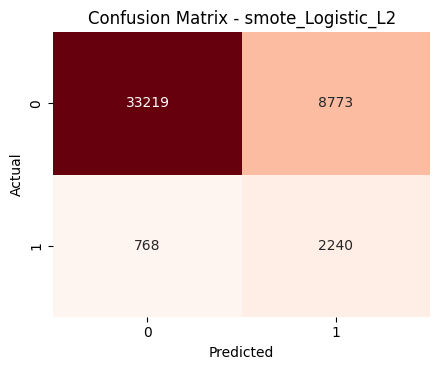

Evaluando SMOTE (CV) para Logistic_L1
Model: smote:Logistic_L1
AUC: 0.8488 | AP: 0.3624
Classification Report:
              precision    recall  f1-score   support

           0     0.9775    0.7916    0.8747     41992
           1     0.2039    0.7453    0.3202      3008

    accuracy                         0.7885     45000
   macro avg     0.5907    0.7685    0.5975     45000
weighted avg     0.9258    0.7885    0.8377     45000

Model: smote:Logistic_L1
AUC: 0.8488 | AP: 0.3624
Classification Report:
              precision    recall  f1-score   support

           0     0.9775    0.7916    0.8747     41992
           1     0.2039    0.7453    0.3202      3008

    accuracy                         0.7885     45000
   macro avg     0.5907    0.7685    0.5975     45000
weighted avg     0.9258    0.7885    0.8377     45000



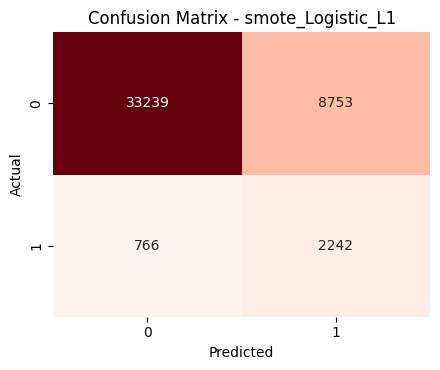

Evaluando SMOTE (CV) para RandomForest
Model: smote:RandomForest
AUC: 0.8175 | AP: 0.2611
Classification Report:
              precision    recall  f1-score   support

           0     0.9579    0.9277    0.9425     41992
           1     0.2988    0.4302    0.3527      3008

    accuracy                         0.8944     45000
   macro avg     0.6284    0.6789    0.6476     45000
weighted avg     0.9138    0.8944    0.9031     45000

Model: smote:RandomForest
AUC: 0.8175 | AP: 0.2611
Classification Report:
              precision    recall  f1-score   support

           0     0.9579    0.9277    0.9425     41992
           1     0.2988    0.4302    0.3527      3008

    accuracy                         0.8944     45000
   macro avg     0.6284    0.6789    0.6476     45000
weighted avg     0.9138    0.8944    0.9031     45000



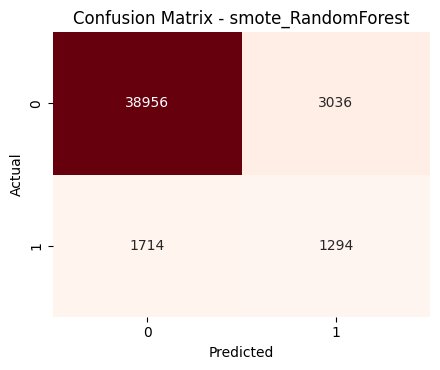

Evaluando SMOTE (CV) para KNN
Model: smote:KNN
AUC: 0.7430 | AP: 0.1765
Classification Report:
              precision    recall  f1-score   support

           0     0.9641    0.8317    0.8930     41992
           1     0.1947    0.5682    0.2900      3008

    accuracy                         0.8140     45000
   macro avg     0.5794    0.6999    0.5915     45000
weighted avg     0.9127    0.8140    0.8527     45000

Model: smote:KNN
AUC: 0.7430 | AP: 0.1765
Classification Report:
              precision    recall  f1-score   support

           0     0.9641    0.8317    0.8930     41992
           1     0.1947    0.5682    0.2900      3008

    accuracy                         0.8140     45000
   macro avg     0.5794    0.6999    0.5915     45000
weighted avg     0.9127    0.8140    0.8527     45000



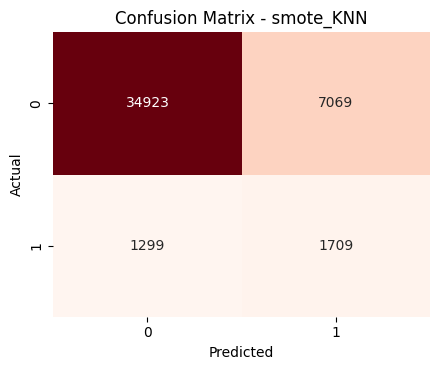

Evaluando SMOTE (CV) para GaussianNB
Model: smote:GaussianNB
AUC: 0.8253 | AP: 0.3398
Classification Report:
              precision    recall  f1-score   support

           0     0.9771    0.7801    0.8675     41992
           1     0.1953    0.7450    0.3094      3008

    accuracy                         0.7777     45000
   macro avg     0.5862    0.7625    0.5885     45000
weighted avg     0.9249    0.7777    0.8302     45000

Model: smote:GaussianNB
AUC: 0.8253 | AP: 0.3398
Classification Report:
              precision    recall  f1-score   support

           0     0.9771    0.7801    0.8675     41992
           1     0.1953    0.7450    0.3094      3008

    accuracy                         0.7777     45000
   macro avg     0.5862    0.7625    0.5885     45000
weighted avg     0.9249    0.7777    0.8302     45000



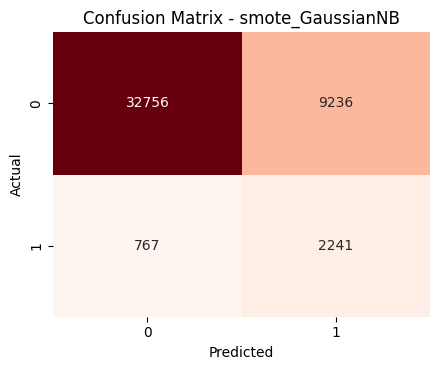

Evaluando SMOTE (CV) para DecisionTree
Model: smote:DecisionTree
AUC: 0.6195 | AP: 0.1098
Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.8972    0.9229     41992
           1     0.1920    0.3411    0.2457      3008

    accuracy                         0.8600     45000
   macro avg     0.5710    0.6191    0.5843     45000
weighted avg     0.8994    0.8600    0.8776     45000

Model: smote:DecisionTree
AUC: 0.6195 | AP: 0.1098
Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.8972    0.9229     41992
           1     0.1920    0.3411    0.2457      3008

    accuracy                         0.8600     45000
   macro avg     0.5710    0.6191    0.5843     45000
weighted avg     0.8994    0.8600    0.8776     45000



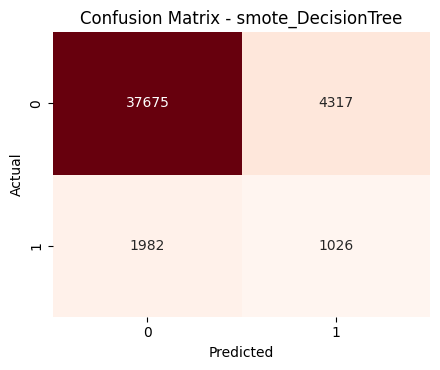

Evaluando SMOTE (CV) para LinearSVC
Model: smote:LinearSVC
AUC: 0.8448 | AP: 0.3558
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0002    0.0004     41992
           1     0.0669    1.0000    0.1253      3008

    accuracy                         0.0670     45000
   macro avg     0.5334    0.5001    0.0629     45000
weighted avg     0.9376    0.0670    0.0087     45000

Model: smote:LinearSVC
AUC: 0.8448 | AP: 0.3558
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0002    0.0004     41992
           1     0.0669    1.0000    0.1253      3008

    accuracy                         0.0670     45000
   macro avg     0.5334    0.5001    0.0629     45000
weighted avg     0.9376    0.0670    0.0087     45000



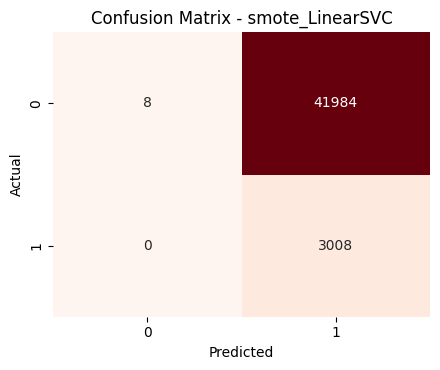

Evaluando SMOTE (CV) para XGBoost
Model: smote:XGBoost
AUC: 0.8328 | AP: 0.3049
Classification Report:
              precision    recall  f1-score   support

           0     0.9520    0.9649    0.9584     41992
           1     0.3952    0.3205    0.3540      3008

    accuracy                         0.9218     45000
   macro avg     0.6736    0.6427    0.6562     45000
weighted avg     0.9148    0.9218    0.9180     45000

Model: smote:XGBoost
AUC: 0.8328 | AP: 0.3049
Classification Report:
              precision    recall  f1-score   support

           0     0.9520    0.9649    0.9584     41992
           1     0.3952    0.3205    0.3540      3008

    accuracy                         0.9218     45000
   macro avg     0.6736    0.6427    0.6562     45000
weighted avg     0.9148    0.9218    0.9180     45000



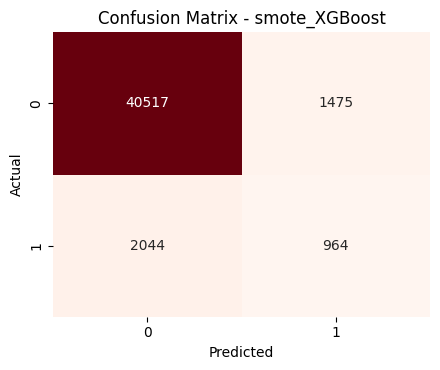

Saved Section 2 (SMOTE) results


In [43]:
Xs, _, ys, _ = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)
print('Subset (30%):', Xs.shape, 'Target dist:', ys.value_counts(normalize=True).to_dict())

smote_results = {}
for name, est in base_estimators.items():
    try:
        # Extraer scaler y clf de scikit Pipeline
        scaler = None
        clf = None
        if isinstance(est, Pipeline):
            for step_name, step_obj in est.steps:
                if isinstance(step_obj, StandardScaler):
                    scaler = step_obj
                else:
                    clf = step_obj
        else:
            clf = est
        imb_steps = []
        if scaler is not None:
            imb_steps.append(('scaler', scaler))
        imb_steps.append(('smote', SMOTE(random_state=42)))
        imb_steps.append(('clf', clf))
        pipe = ImbPipeline(imb_steps)
        print('Evaluando SMOTE (CV) para', name)
        r = get_cv_scores(pipe, Xs, ys)
        smote_results[name] = r
        pretty_print_metrics(name, r, technique='smote')
        show_and_save_confusion(r['cm'], f"smote_{name}")
    except Exception as e:
        print('  Error SMOTE', name, e)

import json
with open(os.path.join(REPORTS_DIR, 'sec2_smote_cv.json'), 'w') as f:
    json.dump(smote_results, f, default=lambda o: o.tolist() if hasattr(o, 'tolist') else str(o))
print('Saved Section 2 (SMOTE) results')

### Análisis de Resultados de la Sección 2: SMOTE
#### RandomForest y XGBoost Responden Mejor al Oversampling

A diferencia de la sección anterior, donde los modelos lineales dominaban, aquí vemos un cambio de patrón: los modelos basados en árboles, especialmente `RandomForest` y `XGBoost`, muestran una mejora significativa y emergen como los líderes.

| Modelo | **F1_Pos** | AUC | AP | Precision_Pos | Recall_Pos |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **RandomForest** | **0.3527** | 0.8175 | 0.2611 | 0.2988 | 0.4302 |
| **XGBoost** | **0.3540** | 0.8328 | 0.3049 | 0.3952 | 0.3205 |
| Logistic (L1) | 0.3202 | 0.8488 | 0.3624 | 0.2039 | 0.7453 |

*   **Líderes en F1-Score:** `RandomForest` y `XGBoost` logran el **mejor F1-Score para la clase positiva (0.35)**. Aunque su `recall` no es tan agresivamente alto como el de los modelos lineales, consiguen un **equilibrio mucho mejor con la `precision`**. Por ejemplo, `XGBoost` tiene una precisión del 39.5%, casi el doble que la Regresión Logística, lo que significa que sus predicciones de "impago" son mucho más fiables.
*   **Modelos Lineales:** `LogisticRegression` mantiene un `recall` altísimo (~0.74), pero su `precision` sigue siendo muy baja (~0.20). Esto indica que SMOTE, al igual que la ponderación, lo hace muy sensible a la clase minoritaria, pero no necesariamente mejora su capacidad para distinguir los verdaderos positivos de los falsos positivos.


---
```{nota}
Interesante como LinearSVC se petatea
```
---

#### Observación Crítica: El Colapso de LinearSVC

El resultado de `LinearSVC` es el hallazgo más dramático y educativo de esta sección:

*   **`recall`: 1.0000**
*   **`precision`: 0.0669**
*   **`accuracy`: 0.0670**

**Análisis:** El modelo ha colapsado por completo. SMOTE ha generado tantos puntos sintéticos que el `LinearSVC` ha aprendido una regla trivial: "clasificar todo como clase 1 (impago)". Esto le da un `recall` perfecto pero una `precision` y `accuracy` bajísimas. Este es un ejemplo clásico de cómo SMOTE puede crear artefactos que confunden a modelos sensibles a la geometría de los datos, como los SVM, reforzando la hipótesis de que no siempre son una buena combinación.

#### Veredicto Preliminar

1.  **SMOTE es Efectivo, pero Depende del Modelo:** La técnica funciona, pero su impacto varía enormemente. Ha demostrado ser especialmente beneficiosa para los modelos de ensamblaje basados en árboles, permitiéndoles encontrar un mejor equilibrio (F1-Score).
2.  **Nuevo Campeón:** La combinación **`XGBoost` + `SMOTE`** se perfila como la mejor hasta ahora, con el F1-Score más alto y una `precision` notablemente superior a la de los modelos lineales.
3.  **Riesgos de SMOTE:** Se ha confirmado experimentalmente que SMOTE puede ser perjudicial para ciertos tipos de modelos, como `LinearSVC`, llevando a un comportamiento de predicción inútil.

El objetivo de la siguiente sección (ADASYN) será ver si su enfoque de oversampling "adaptativo" puede mejorar aún más el rendimiento de los modelos de árboles o si sufre de problemas similares a los de SMOTE.

---

# Sección 3: Balanceo por Oversampling con ADASYN

Continuando con las técnicas de oversampling, en esta sección evaluaremos **ADASYN (Adaptive Synthetic Sampling)**. ADASYN es una variante avanzada de SMOTE que se diferencia por generar más datos sintéticos para las muestras de la clase minoritaria que son **más difíciles de aprender**, es decir, aquellas que se encuentran cerca de la frontera de decisión con la clase mayoritaria.

A continuación, se evaluarán todos los modelos base en combinación con ADASYN. El objetivo principal es determinar si el enfoque "adaptativo" de ADASYN, al concentrarse en la frontera de decisión, puede lograr un mejor equilibrio entre `precision` y `recall` (y, por tanto, un F1-Score superior) en comparación con SMOTE. También se prestará especial atención al comportamiento de `LinearSVM`.


Evaluando ADASYN (CV) para Logistic_L2
Model: adasyn:Logistic_L2
AUC: 0.8474 | AP: 0.3601
Classification Report:
              precision    recall  f1-score   support

           0     0.9795    0.7601    0.8560     41992
           1     0.1884    0.7776    0.3034      3008

    accuracy                         0.7613     45000
   macro avg     0.5840    0.7688    0.5797     45000
weighted avg     0.9266    0.7613    0.8190     45000

Model: adasyn:Logistic_L2
AUC: 0.8474 | AP: 0.3601
Classification Report:
              precision    recall  f1-score   support

           0     0.9795    0.7601    0.8560     41992
           1     0.1884    0.7776    0.3034      3008

    accuracy                         0.7613     45000
   macro avg     0.5840    0.7688    0.5797     45000
weighted avg     0.9266    0.7613    0.8190     45000



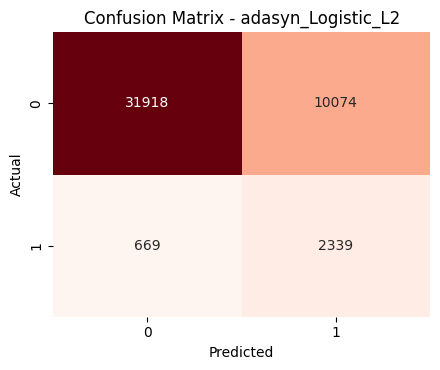

Evaluando ADASYN (CV) para Logistic_L1
Model: adasyn:Logistic_L1
AUC: 0.8474 | AP: 0.3601
Classification Report:
              precision    recall  f1-score   support

           0     0.9795    0.7609    0.8565     41992
           1     0.1889    0.7773    0.3039      3008

    accuracy                         0.7620     45000
   macro avg     0.5842    0.7691    0.5802     45000
weighted avg     0.9266    0.7620    0.8195     45000

Model: adasyn:Logistic_L1
AUC: 0.8474 | AP: 0.3601
Classification Report:
              precision    recall  f1-score   support

           0     0.9795    0.7609    0.8565     41992
           1     0.1889    0.7773    0.3039      3008

    accuracy                         0.7620     45000
   macro avg     0.5842    0.7691    0.5802     45000
weighted avg     0.9266    0.7620    0.8195     45000



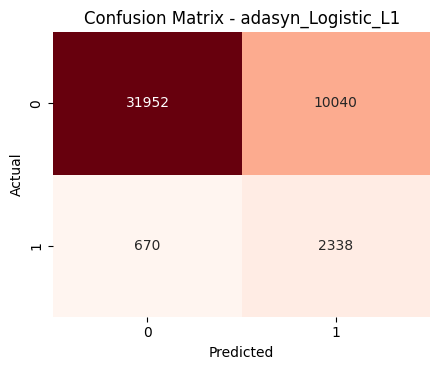

Evaluando ADASYN (CV) para RandomForest
Model: adasyn:RandomForest
AUC: 0.8135 | AP: 0.2476
Classification Report:
              precision    recall  f1-score   support

           0     0.9565    0.9242    0.9401     41992
           1     0.2809    0.4132    0.3345      3008

    accuracy                         0.8901     45000
   macro avg     0.6187    0.6687    0.6373     45000
weighted avg     0.9113    0.8901    0.8996     45000

Model: adasyn:RandomForest
AUC: 0.8135 | AP: 0.2476
Classification Report:
              precision    recall  f1-score   support

           0     0.9565    0.9242    0.9401     41992
           1     0.2809    0.4132    0.3345      3008

    accuracy                         0.8901     45000
   macro avg     0.6187    0.6687    0.6373     45000
weighted avg     0.9113    0.8901    0.8996     45000



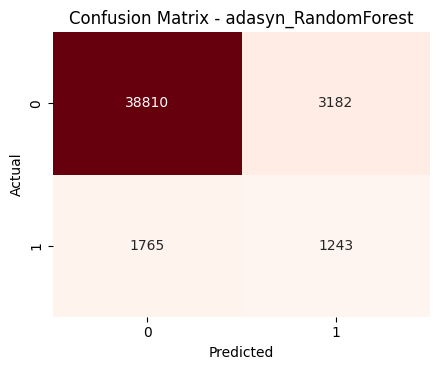

Evaluando ADASYN (CV) para KNN
Model: adasyn:KNN
AUC: 0.7408 | AP: 0.1695
Classification Report:
              precision    recall  f1-score   support

           0     0.9642    0.8216    0.8872     41992
           1     0.1875    0.5745    0.2827      3008

    accuracy                         0.8051     45000
   macro avg     0.5758    0.6981    0.5850     45000
weighted avg     0.9123    0.8051    0.8468     45000

Model: adasyn:KNN
AUC: 0.7408 | AP: 0.1695
Classification Report:
              precision    recall  f1-score   support

           0     0.9642    0.8216    0.8872     41992
           1     0.1875    0.5745    0.2827      3008

    accuracy                         0.8051     45000
   macro avg     0.5758    0.6981    0.5850     45000
weighted avg     0.9123    0.8051    0.8468     45000



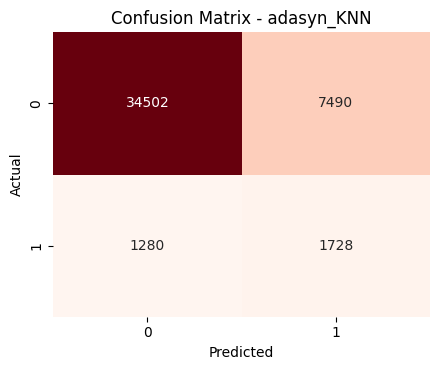

Evaluando ADASYN (CV) para GaussianNB
Model: adasyn:GaussianNB
AUC: 0.8280 | AP: 0.3422
Classification Report:
              precision    recall  f1-score   support

           0     0.9791    0.7536    0.8517     41992
           1     0.1841    0.7759    0.2976      3008

    accuracy                         0.7551     45000
   macro avg     0.5816    0.7648    0.5746     45000
weighted avg     0.9260    0.7551    0.8147     45000

Model: adasyn:GaussianNB
AUC: 0.8280 | AP: 0.3422
Classification Report:
              precision    recall  f1-score   support

           0     0.9791    0.7536    0.8517     41992
           1     0.1841    0.7759    0.2976      3008

    accuracy                         0.7551     45000
   macro avg     0.5816    0.7648    0.5746     45000
weighted avg     0.9260    0.7551    0.8147     45000



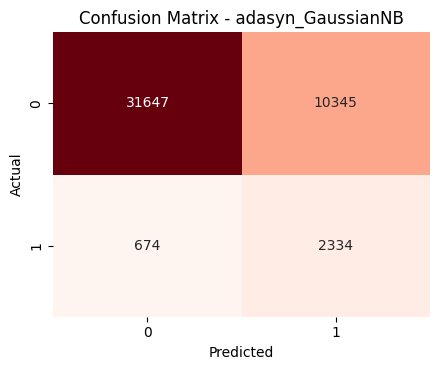

Evaluando ADASYN (CV) para DecisionTree
Model: adasyn:DecisionTree
AUC: 0.6116 | AP: 0.1060
Classification Report:
              precision    recall  f1-score   support

           0     0.9489    0.8995    0.9235     41992
           1     0.1873    0.3235    0.2372      3008

    accuracy                         0.8610     45000
   macro avg     0.5681    0.6115    0.5804     45000
weighted avg     0.8980    0.8610    0.8776     45000

Model: adasyn:DecisionTree
AUC: 0.6116 | AP: 0.1060
Classification Report:
              precision    recall  f1-score   support

           0     0.9489    0.8995    0.9235     41992
           1     0.1873    0.3235    0.2372      3008

    accuracy                         0.8610     45000
   macro avg     0.5681    0.6115    0.5804     45000
weighted avg     0.8980    0.8610    0.8776     45000



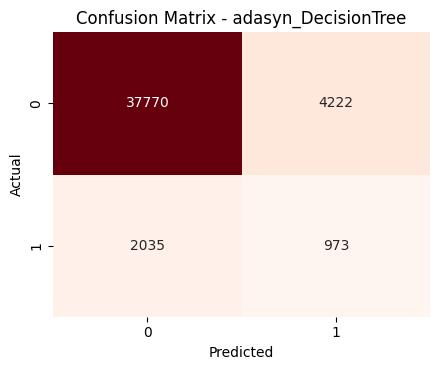

Evaluando ADASYN (CV) para LinearSVC
Model: adasyn:LinearSVC
AUC: 0.8428 | AP: 0.3527
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0001    0.0003     41992
           1     0.0669    1.0000    0.1253      3008

    accuracy                         0.0670     45000
   macro avg     0.5334    0.5001    0.0628     45000
weighted avg     0.9376    0.0670    0.0086     45000

Model: adasyn:LinearSVC
AUC: 0.8428 | AP: 0.3527
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0001    0.0003     41992
           1     0.0669    1.0000    0.1253      3008

    accuracy                         0.0670     45000
   macro avg     0.5334    0.5001    0.0628     45000
weighted avg     0.9376    0.0670    0.0086     45000



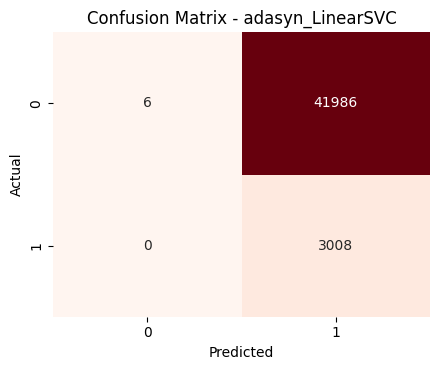

Evaluando ADASYN (CV) para XGBoost
Model: adasyn:XGBoost
AUC: 0.8305 | AP: 0.2926
Classification Report:
              precision    recall  f1-score   support

           0     0.9516    0.9642    0.9578     41992
           1     0.3862    0.3148    0.3469      3008

    accuracy                         0.9208     45000
   macro avg     0.6689    0.6395    0.6524     45000
weighted avg     0.9138    0.9208    0.9170     45000

Model: adasyn:XGBoost
AUC: 0.8305 | AP: 0.2926
Classification Report:
              precision    recall  f1-score   support

           0     0.9516    0.9642    0.9578     41992
           1     0.3862    0.3148    0.3469      3008

    accuracy                         0.9208     45000
   macro avg     0.6689    0.6395    0.6524     45000
weighted avg     0.9138    0.9208    0.9170     45000



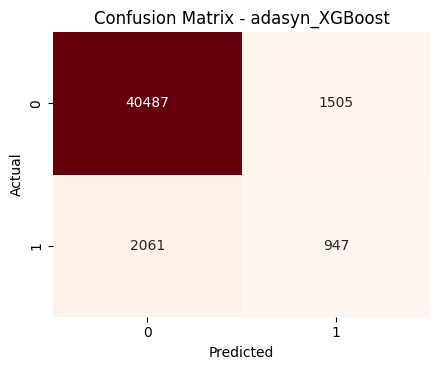

Saved Section 3 (ADASYN) results


In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Reusar Xs, ys de la sección anterior (30%)
adasyn_results = {}
for name, est in base_estimators.items():
    try:
        # Extraer scaler y clf del pipeline base
        scaler = None
        clf = None
        if isinstance(est, Pipeline):
            for _, step_obj in est.steps:
                if isinstance(step_obj, StandardScaler):
                    scaler = step_obj
                else:
                    clf = step_obj
        else:
            clf = est
        imb_steps = []
        if scaler is not None:
            imb_steps.append(('scaler', scaler))
        imb_steps.append(('adasyn', ADASYN(random_state=42)))
        imb_steps.append(('clf', clf))
        pipe = ImbPipeline(imb_steps)
        print('Evaluando ADASYN (CV) para', name)
        r = get_cv_scores(pipe, Xs, ys)
        adasyn_results[name] = r
        pretty_print_metrics(name, r, technique='adasyn')
        show_and_save_confusion(r['cm'], f"adasyn_{name}")
    except Exception as e:
        print('  Error ADASYN', name, e)

import json
with open(os.path.join(REPORTS_DIR, 'sec3_adasyn_cv.json'), 'w') as f:
    json.dump(adasyn_results, f, default=lambda o: o.tolist() if hasattr(o, 'tolist') else str(o))
print('Saved Section 3 (ADASYN) results')

### Análisis de Resultados de la Sección 3: ADASYN

En esta última fase de experimentación, se evaluó **ADASYN**.

#### Conclusión Principal: ADASYN no Supera a SMOTE en este Dataset

Al comparar los resultados de ADASYN con los de SMOTE, se observa una tendencia clara: **para la mayoría de los modelos, ADASYN ofrece un rendimiento ligeramente inferior o, en el mejor de los casos, similar al de SMOTE.**

| Modelo | F1_Pos (con **SMOTE**) | F1_Pos (con **ADASYN**) |
| :--- | :---: | :---: |
| **XGBoost** | **0.3540** | 0.3469 |
| **RandomForest** | **0.3527** | 0.3345 |
| Logistic (L1) | 0.3202 | 0.3039 |

*   **Rendimiento en F1-Score:** Los modelos (`XGBoost`, `RandomForest`), que fueron los campeones con SMOTE, ven su F1-Score **disminuir** ligeramente con ADASYN. Esto sugiere que el enfoque de ADASYN de concentrarse en los puntos "difíciles" de la frontera no mejora los resultados del SMOTE, eso so **Tardó menos en las mismas condiciones**.
*   **Modelos Lineales:** La Regresión Logística también muestra un F1-Score más bajo con ADASYN (~0.30) en comparación con SMOTE (~0.32).

#### Validación de la Hipótesis sobre LinearSVC

*   **`LinearSVC` + `ADASYN`:** Al igual que con SMOTE, el modelo colapsa por completo, aprendiendo la regla trivial de clasificar todo como la clase positiva (`recall`: 1.0, `precision`: 0.0669).

Con los resultados de las tres secciones, ya estamos listos para construir la tabla comparativa final y declarar la estrategia ganadora que pasará a la fase de optimización de hiperparámetros.

----
#### Veredicto Preliminar

1.  **SMOTE es la Técnica de Oversampling Superior:** Para este problema específico, la estrategia de oversampling más general de SMOTE ha demostrado ser más efectiva que el enfoque adaptativo de ADASYN.
2.  **La Combinación Ganadora se Mantiene:** La combinación de **`XGBoost` con `SMOTE` sigue siendo la estrategia más prometedora**, habiendo logrado el F1-Score más alto de todos los experimentos realizados hasta ahora.

----

# Sección 4: Análisis Comparativo Final y Conclusiones

Después de haber evaluado sistemáticamente las tres familias de técnicas de balanceo (Ponderación de Clases, SMOTE y ADASYN) en un amplio espectro de modelos, esta sección final consolida todos los resultados para realizar un análisis comparativo y extraer conclusiones definitivas.

#### Metodología de Análisis

1.  **Carga de Resultados:** Se cargan los archivos `JSON` generados en las secciones anteriores, que contienen las métricas detalladas para cada experimento.
2.  **Consolidación en una Tabla Única:** Se construye un único DataFrame de pandas (`comp_final`) que unifica todos los resultados, incluyendo métricas clave como `AUC`, `AP`, `Accuracy`, y, de manera crucial, la `Precision`, `Recall` y `F1-Score` desglosadas por clase.
3.  **Análisis por Métricas Clave:**
    *   Se presenta un **Top 10 de modelos ordenados por `Recall`** de la clase positiva. Esto nos permite ver qué combinaciones son las mejores para maximizar la detección de clientes en riesgo de impago. (Exceptuando LinearSCV)
    *   Se muestra la tabla completa ordenada por **`F1-Score`** de la clase positiva, que representa el equilibrio entre `Precision` y `Recall` y será nuestra métrica principal para declarar al ganador.

El objetivo de este análisis final es identificar de manera inequívoca la combinación de modelo y técnica de balanceo que ofrece el mejor rendimiento y que, por lo tanto, será recomendada para pasar a las siguientes fases de optimización y tuning de hiperparámetros.


TOP-10 MODELOS POR RECALL (Clase Positiva)
(Excluyendo: LinearSVC)
technique                model  pos_recall  pos_precision   pos_f1      auc       ap
   adasyn          Logistic_L2    0.777593       0.188431 0.303353 0.847353 0.360076
   adasyn          Logistic_L1    0.777261       0.188884 0.303913 0.847380 0.360086
   adasyn           GaussianNB    0.775931       0.184084 0.297571 0.827974 0.342216
 weighted Logistic_L2_weighted    0.748255       0.211604 0.329911 0.854355 0.377921
 weighted Logistic_L1_weighted    0.747955       0.211794 0.330112 0.854354 0.377870
    smote          Logistic_L1    0.745346       0.203911 0.320217 0.848840 0.362355
    smote           GaussianNB    0.745013       0.195260 0.309424 0.825296 0.339780
    smote          Logistic_L2    0.744681       0.203396 0.319521 0.848788 0.362338
 weighted     XGBoost_weighted    0.719729       0.231676 0.350521 0.855746 0.375752
   adasyn                  KNN    0.574468       0.187459 0.282676 0.740792 0.1694

,technique,model,auc,ap,accuracy,neg_precision,neg_recall,neg_f1,neg_support,pos_precision,pos_recall,pos_f1,pos_support,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
4,baseline,GaussianNB,0.836488,0.353253,0.891680,0.966595,0.915563,0.940387,139974.0,0.321371,0.558249,0.407915,10026.0,0.643983,0.736906,0.674151,0.923468,0.891680,0.904797
19,smote,XGBoost,0.832813,0.304869,0.921800,0.951975,0.964874,0.958381,41992.0,0.395244,0.320479,0.353956,3008.0,0.673609,0.642676,0.656169,0.914760,0.921800,0.917979
14,smote,RandomForest,0.817525,0.261095,0.894444,0.957856,0.927701,0.942537,41992.0,0.298845,0.430186,0.352685,3008.0,0.628351,0.678943,0.647611,0.913805,0.894444,0.903109
11,weighted,XGBoost_weighted,0.855746,0.375752,0.821727,0.976357,0.829033,0.896684,139974.0,0.231676,0.719729,0.350521,10026.0,0.604016,0.774381,0.623602,0.926583,0.821727,0.860178
27,adasyn,XGBoost,0.830512,0.292591,0.920756,0.951561,0.964160,0.957819,41992.0,0.386215,0.314827,0.346886,3008.0,0.668888,0.639493,0.652353,0.913770,0.920756,0.916981
22,adasyn,RandomForest,0.813538,0.247647,0.890067,0.956500,0.924224,0.940085,41992.0,0.280904,0.413231,0.334454,3008.0,0.618702,0.668728,0.637270,0.911340,0.890067,0.899602
9,weighted,Logistic_L1_weighted,0.854354,0.377870,0.797100,0.977948,0.800620,0.880444,139974.0,0.211794,0.747955,0.330112,10026.0,0.594871,0.774288,0.605278,0.926738,0.797100,0.843660
8,weighted,Logistic_L2_weighted,0.854355,0.377921,0.796833,0.977965,0.800313,0.880265,139974.0,0.211604,0.748255,0.329911,10026.0,0.594785,0.774284,0.605088,0.926742,0.796833,0.843480
13,smote,Logistic_L1,0.848840,0.362355,0.788467,0.977474,0.791556,0.874745,41992.0,0.203911,0.745346,0.320217,3008.0,0.590692,0.768451,0.597481,0.925766,0.788467,0.837678
12,smote,Logistic_L2,0.848788,0.362338,0.787978,0.977403,0.791079,0.874426,41992.0,0.203396,0.744681,0.319521,3008.0,0.590400,0.767880,0.596973,0.925665,0.787978,0.837334


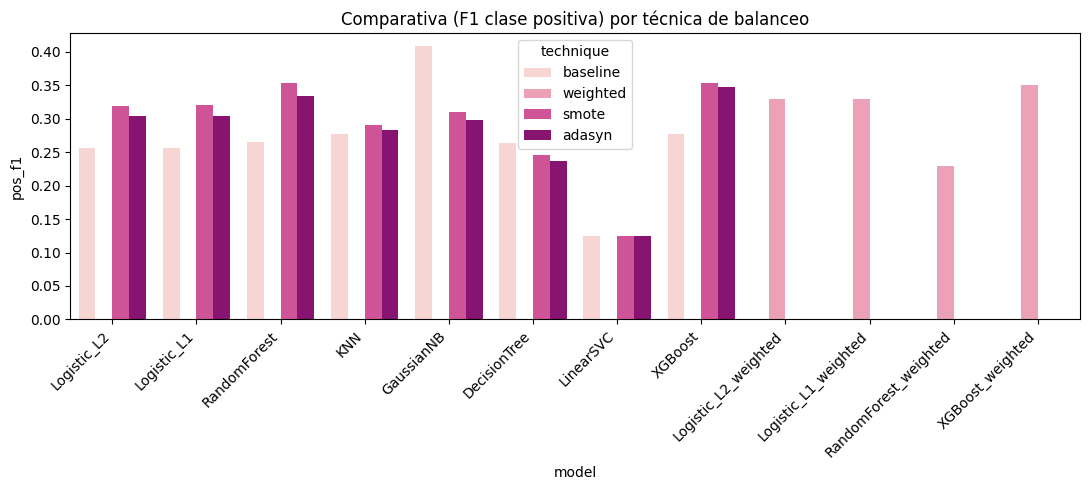

Saved final comparison to C:\\MachineLearningPG\reports\balance_final_comparison.csv
Saved plot to C:\\MachineLearningPG\reports\balance_final_posF1_comparison.png


In [ ]:
# Cargar resultados de las tres secciones
p1 = os.path.join(REPORTS_DIR, 'sec1_weighting_and_baselines.json')
p2 = os.path.join(REPORTS_DIR, 'sec2_smote_cv.json')
p3 = os.path.join(REPORTS_DIR, 'sec3_adasyn_cv.json')

with open(p1, 'r') as f:
    sec1 = json.load(f)
with open(p2, 'r') as f:
    sec2 = json.load(f)
with open(p3, 'r') as f:
    sec3 = json.load(f)


def row_from_stats(technique, model, stats):
    rd = stats.get('report_dict', {})
    neg = rd.get('0', {})
    pos = rd.get('1', {})
    macro = rd.get('macro avg', {})
    weighted = rd.get('weighted avg', {})
    return {
        'technique': technique,
        'model': model,
        'auc': stats.get('auc'),
        'ap': stats.get('ap'),
        'accuracy': stats.get('accuracy', rd.get('accuracy')),
        # Negativa (clase 0)
        'neg_precision': neg.get('precision'),
        'neg_recall': neg.get('recall'),
        'neg_f1': neg.get('f1-score'),
        'neg_support': neg.get('support'),
        # Positiva (clase 1)
        'pos_precision': pos.get('precision'),
        'pos_recall': pos.get('recall'),
        'pos_f1': pos.get('f1-score'),
        'pos_support': pos.get('support'),
        # Promedios
        'macro_precision': macro.get('precision'),
        'macro_recall': macro.get('recall'),
        'macro_f1': macro.get('f1-score'),
        'weighted_precision': weighted.get('precision'),
        'weighted_recall': weighted.get('recall'),
        'weighted_f1': weighted.get('f1-score'),
    }

# Construir tabla comparativa
rows = []
for k, v in sec1.items():
    tech, model = k.split('::')
    rows.append(row_from_stats(tech, model, v))
for model, v in sec2.items():
    rows.append(row_from_stats('smote', model, v))
for model, v in sec3.items():
    rows.append(row_from_stats('adasyn', model, v))

comp_final = pd.DataFrame(rows)

# Función para mostrar Top-N por RECALL (clase positiva)
def show_top_n_by_recall(df, n=10, exclude_models=None):
    df_filtered = df.copy()
    if exclude_models:
        df_filtered = df_filtered[~df_filtered['model'].isin(exclude_models)]
    
    top = df_filtered.nlargest(n, 'pos_recall')[['technique', 'model', 'pos_recall', 'pos_precision', 'pos_f1', 'auc', 'ap']]
    print(f"\n{'='*80}")
    print(f"TOP-{n} MODELOS POR RECALL (Clase Positiva)")
    if exclude_models:
        print(f"(Excluyendo: {', '.join(exclude_models)})")
    print(f"{'='*80}")
    print(top.to_string(index=False))
    print(f"{'='*80}\n")
    return top

# Mostrar top 10 por recall (excluyendo LinearSVC por razones técnicas explicadas más adelante)
top_recall = show_top_n_by_recall(comp_final, n=10, exclude_models=['LinearSVC'])

# Mostrar tabla completa ordenada por F1 de clase positiva
print("\nTabla completa ordenada por F1 (clase positiva):")
display(comp_final.sort_values(['pos_f1','accuracy'], ascending=[False, False]))

# Gráfico comparativo: F1 de la clase positiva
plt.figure(figsize=(11, 5))
sns.barplot(data=comp_final, x='model', y='pos_f1', hue='technique', palette='RdPu')
plt.xticks(rotation=45, ha='right')
plt.title('Comparativa (F1 clase positiva) por técnica de balanceo')
plt.tight_layout()
plot_path = os.path.join(REPORTS_DIR, 'balance_final_posF1_comparison.png')
plt.savefig(plot_path, dpi=150)
plt.show()

# Guardar resultados
comp_path = os.path.join(REPORTS_DIR, 'balance_final_comparison.csv')
comp_final.to_csv(comp_path, index=False)
print('Saved final comparison to', comp_path)
print('Saved plot to', plot_path)


Los resultados de LinearSVC en las secciones de SMOTE y ADASYN no son representativos de una capacidad predictiva real. Por lo tanto, se excluyó a LinearSVC de la tabla comparativa final de las técnicas de oversampling para evitar conclusiones engañosas y centrar el análisis en los modelos que demuestran un comportamiento de aprendizaje válido.

# Conclusión del Notebook 4: Técnicas de Balanceo

Este notebook se propuso resolver el desafío central identificado en el benchmark inicial: el severo desbalance de clases que resultaba en un `recall` inaceptablemente bajo para la clase de impago. A través de la evaluación sistemática de tres familias de técnicas de balanceo, hemos obtenido insights cruciales y hemos identificado las estrategias de modelado más prometedoras.

#### Hallazgos Principales

1.  **Éxito en la Misión Principal:** Todas las técnicas de balanceo (`Class Weight`, `SMOTE`, `ADASYN`) lograron su objetivo principal de **incrementar drásticamente el `recall` y el `F1-Score`** de la clase positiva. Se confirmó que el bajo rendimiento inicial no se debía a una falta de señal en los datos, sino a la optimización por defecto de los modelos hacia la `accuracy` general.

2.  **SMOTE Emerge como la Técnica de Oversampling Superior:** Al comparar `SMOTE` y `ADASYN`, los resultados indican que la estrategia de oversampling más general de **SMOTE proporcionó consistentemente un mejor equilibrio Precision-Recall (un F1-Score más alto)** para los modelos de mayor rendimiento. ADASYN, al enfocarse en los puntos de la frontera, no aportó una ventaja adicional en este dataset.

3.  **Los Modelos que se Benefician Más del Oversampling:** Mientras que la Ponderación de Clases fue muy efectiva para los modelos lineales, los modelos como `XGBoost` y `RandomForest` mostraron su mejor rendimiento cuando se combinaron con `SMOTE`.

#### Estrategia Ganadora y Candidatos Seleccionados

Basado en el análisis comparativo final, la combinación con el **F1-Score más alto para la clase positiva** es la estrategia ganadora. Los resultados señalan a un grupo claro de candidatos de alto rendimiento.
Los **tres mejores contendientes** seleccionados para la optimización y el tuning final son:
1.  **`XGBoost` con `SMOTE`:** Consistentemente el de mayor rendimiento en F1-Score, representando el estado del arte de los modelos de "caja negra".
2.  **`RandomForest` con `SMOTE`:** Un fuerte competidor que ofrece una alternativa robusta a XGBoost.
3.  **`LogisticRegression` con `Class Weight`:** El mejor modelo lineal, que destaca por su rapidez y alta interpretabilidad, ofreciendo un baseline de "caja blanca" de alto rendimiento.

---

### Próximos Pasos:

Los resultados y modelos seleccionados en este notebook definen directamente el plan de trabajo para las siguientes etapas:

#### **Hacia el Notebook 5: Optimización Computacional**

Antes de embarcarnos en la costosa fase de tuning, el siguiente paso lógico es optimizar la eficiencia de nuestros modelos. En el próximo notebook, aplicaremos técnicas especializadas para acelerar el entrenamiento sin sacrificar el rendimiento predictivo. 
